In [187]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
import random
%matplotlib inline

In [188]:
#read data
file_name = 'forestfire.txt'
file = open(file_name , 'r')
lines = file.readlines()
data = []

for l in lines:
    data.append(l.split(','))
    
random.shuffle(data)
#extract required data
for y in range(len(data)):
    data[y][3] = 1 #ignore day
    if data[y][2] in {'jul','jun','aug'} : # summer months
        data[y][2] = 1
    else :
        data[y][2] = 0
    data[y] = [float(row) for row in data[y]]
N = len(X)
N1 = (len(X)*7)//10 + 1
N2 = N - N1
print('N2/N1 : ' + str(round(N2/N1,3)))
print('3/7   : ' + str(round( 3/7,3)))

N2/N1 : 0.428
3/7   : 0.429


In [189]:
#информация для оценивания качества модели
max_area = np.max(data,axis=0)[-1]
mid_area = np.mean(data,axis=0)[-1]
print(max_area)
print(mid_area)

1090.84
12.8472920696


In [190]:
def MQ_evaluation(Z,X) :
    return (Z.T * Z).I * Z.T * X

In [191]:
def get_evaluation(sample,f) :
        Z = np.matrix([line[:-1] for line in sample])
        X = np.matrix([f(line[-1]) for line in sample]).T
        return MQ_evaluation(Z,X)

In [192]:
def get_prediction(data,evl) :
    test_data = np.matrix([line[:-1] for line in data])
    predict = np.array(test_data * evl)
    return predict

In [193]:
def test_evaluation(data , f , f_inv) :
    learn_sample = data[:N1+1]
    test_sample = data[N1+1:]
    
    evl = get_evaluation(learn_sample, f)

    prediction = get_prediction(test_sample, evl)
    prediction_inv = f_inv(prediction)
    
    expected = [f(line[-1]) for line in test_sample]
    expected_inv = [(line[-1]) for line in test_sample]
    
    return (np.std(expected - prediction) , np.std(expected_inv - prediction_inv))

In [194]:
std , std_inv = test_evaluation(data, (lambda x: x), (lambda x: x))
print("standart deviation = " + str(round(std,4)))

standart deviation = 32.4379


$ \overline{X} < s \ll X_{(n)}$

Получили достаточно большое отклонение, в несколько раз превосходящее среднее значение. С другой стороны оно сильно меньше максимального значения.

In [195]:
OC = np.arange(0.5 , 1000 , 0.5)
std = np.zeros(len(OC))
std_inv = np.zeros(len(OC))
for i in range(len(OC)):
    c = OC[i]
    std[i] , std_inv[i] = test_evaluation(data, (lambda x: math.log(x+c)), (lambda x: np.exp(x) - c))

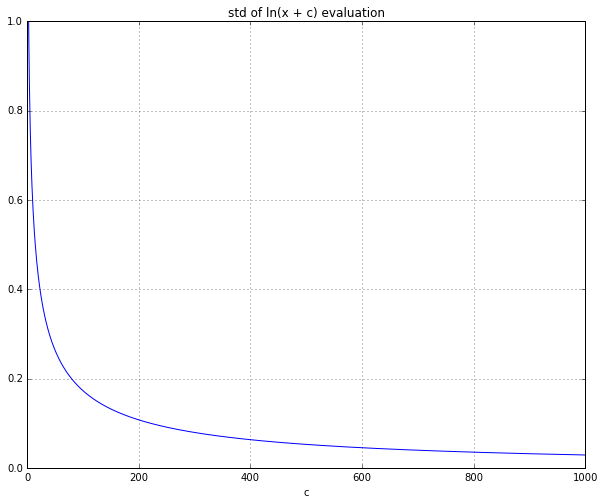

In [196]:
plt.figure(figsize=(10,8))
plt.plot(OC,std)
plt.ylim([0,1])
plt.title(r'std of ln(x + c) evaluation')
plt.xlabel('c')
plt.grid(True)
plt.show()

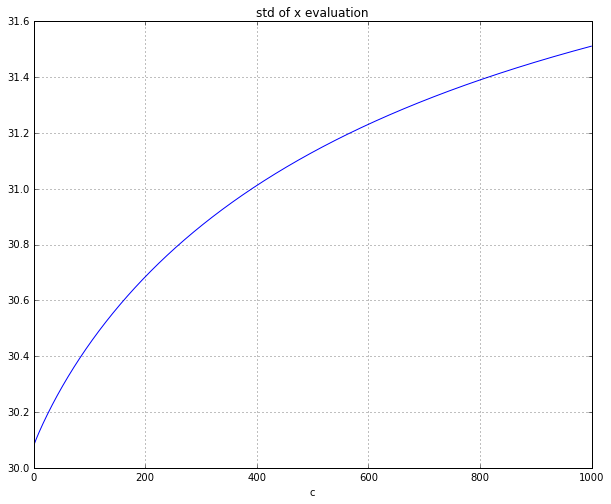

In [197]:
plt.figure(figsize=(10,8))
plt.plot(OC,std_inv)
plt.title(r'std of x evaluation')
plt.xlabel('c')
plt.grid(True)
plt.show()

При увеличении $c$ ошибка по $ln(x + c)$ уменьшается, но ошибка оценки результатов в исходном виде увеличивается. 

Поэтому лучше брать $с$ наименьшим из допустимого.

In [221]:
c = 1e-8
n_tests = 1000
std = np.zeros(n_tests)
std_inv = np.zeros(n_tests)
for i in range(n_tests) :
    np.random.shuffle(data)
    std[i] , std_inv[i] = test_evaluation(data,
                                          (lambda x: math.log(x+c)),
                                          (lambda x: np.exp(x) - c))

max_err = np.max(std_inv)
min_err = np.min(std_inv)
mean_err = np.mean(std_inv)

In [222]:
print('max error = ' + str(max_err))
print('min error = ' + str(min_err))
print('mean error = ' + str(mean_err))

max error = 360.109337371
min error = 11.7885915244
mean error = 55.3087592518


В зависимости от разбиения величина ошибок сильно меняется, максимальная ошибка во много раз превышает среднее значение, поэтому данная модель плохо подходит для точного оценивания.